In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels
import json
import urllib
import gzip
import re

In [2]:
from urllib.request import Request, urlopen

req = Request("http://data.nextstrain.org/ncov.json")
html = gzip.decompress(urlopen(req).read()).decode('utf-8')
ncov_json = json.loads(html)

# Nucleotide mutations

In [5]:
def get_nuc_mutations(data):
    mutation = []
    
    if 'branch_attrs' in data and 'mutations' in data['branch_attrs']:
        for mut_type in data['branch_attrs']['mutations'].keys():
            if mut_type == 'nuc':
                mutation = data['branch_attrs']['mutations'][mut_type]
    
    children_data = [d for child in data.get('children',[]) for d in get_nuc_mutations(child)]
    return [mutation] + children_data

mutations = get_nuc_mutations(ncov_json['tree'])
mutations = [j for i in mutations for j in i]

In [6]:
mutation_re = re.compile("([ACTG])(\d+)([ACTG])")
mutation_re.match('C8782T').groups()
data = [mutation_re.match(m).groups() for m in mutations]
df = pd.DataFrame(data, columns=['from', 'pos', 'to'])
df['pos'] = df['pos'].map(int)
df = df[['pos', 'from', 'to']]
df.head()
#df.to_csv('data.csv')

,pos,from,to
0,7016,G,A
1,21137,A,G
2,27754,G,T
3,28851,G,T
4,8001,A,C


In [7]:
df['change'] = df['from'] + df['to']
df.groupby('change').count()[['pos']].sort_values(by='pos', ascending=False)

,pos
change,
CT,372
GT,131
AG,107
TC,102
GA,94
CA,27
TA,27
TG,24
AC,20


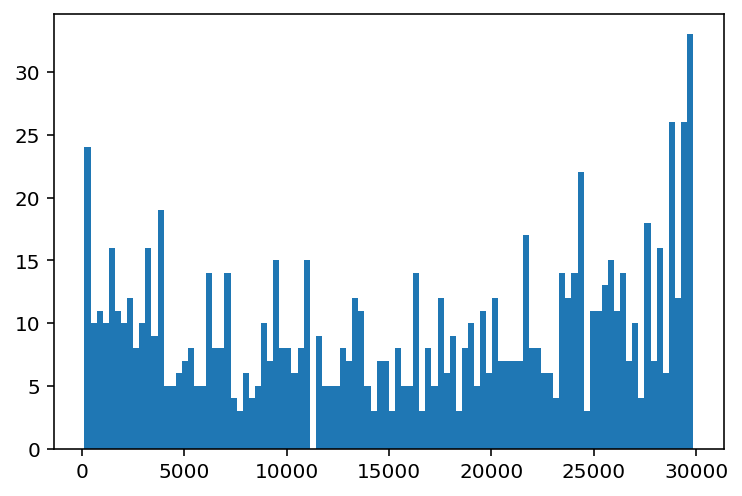

In [8]:
plt.hist(df['pos'], bins=100);

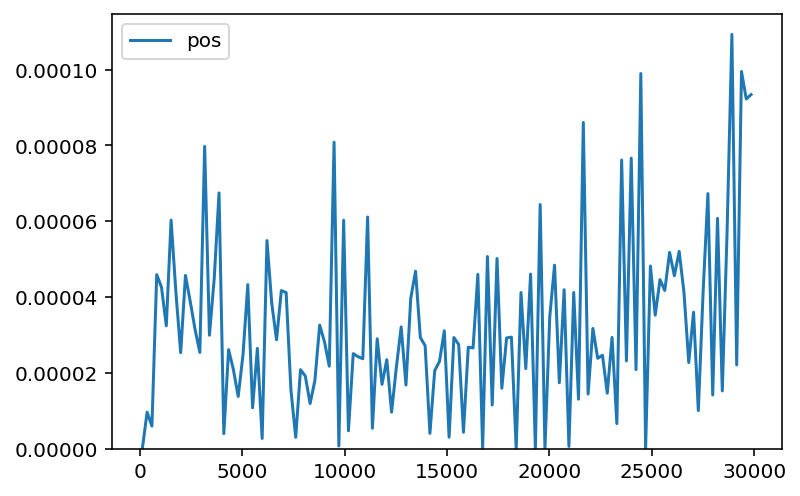

In [9]:
from statsmodels.nonparametric.kde import kernel_switch
sns.kdeplot(df['pos'], bw=.015)

In [10]:
#plt.subplots(3, 1, figsize=(30, 10))

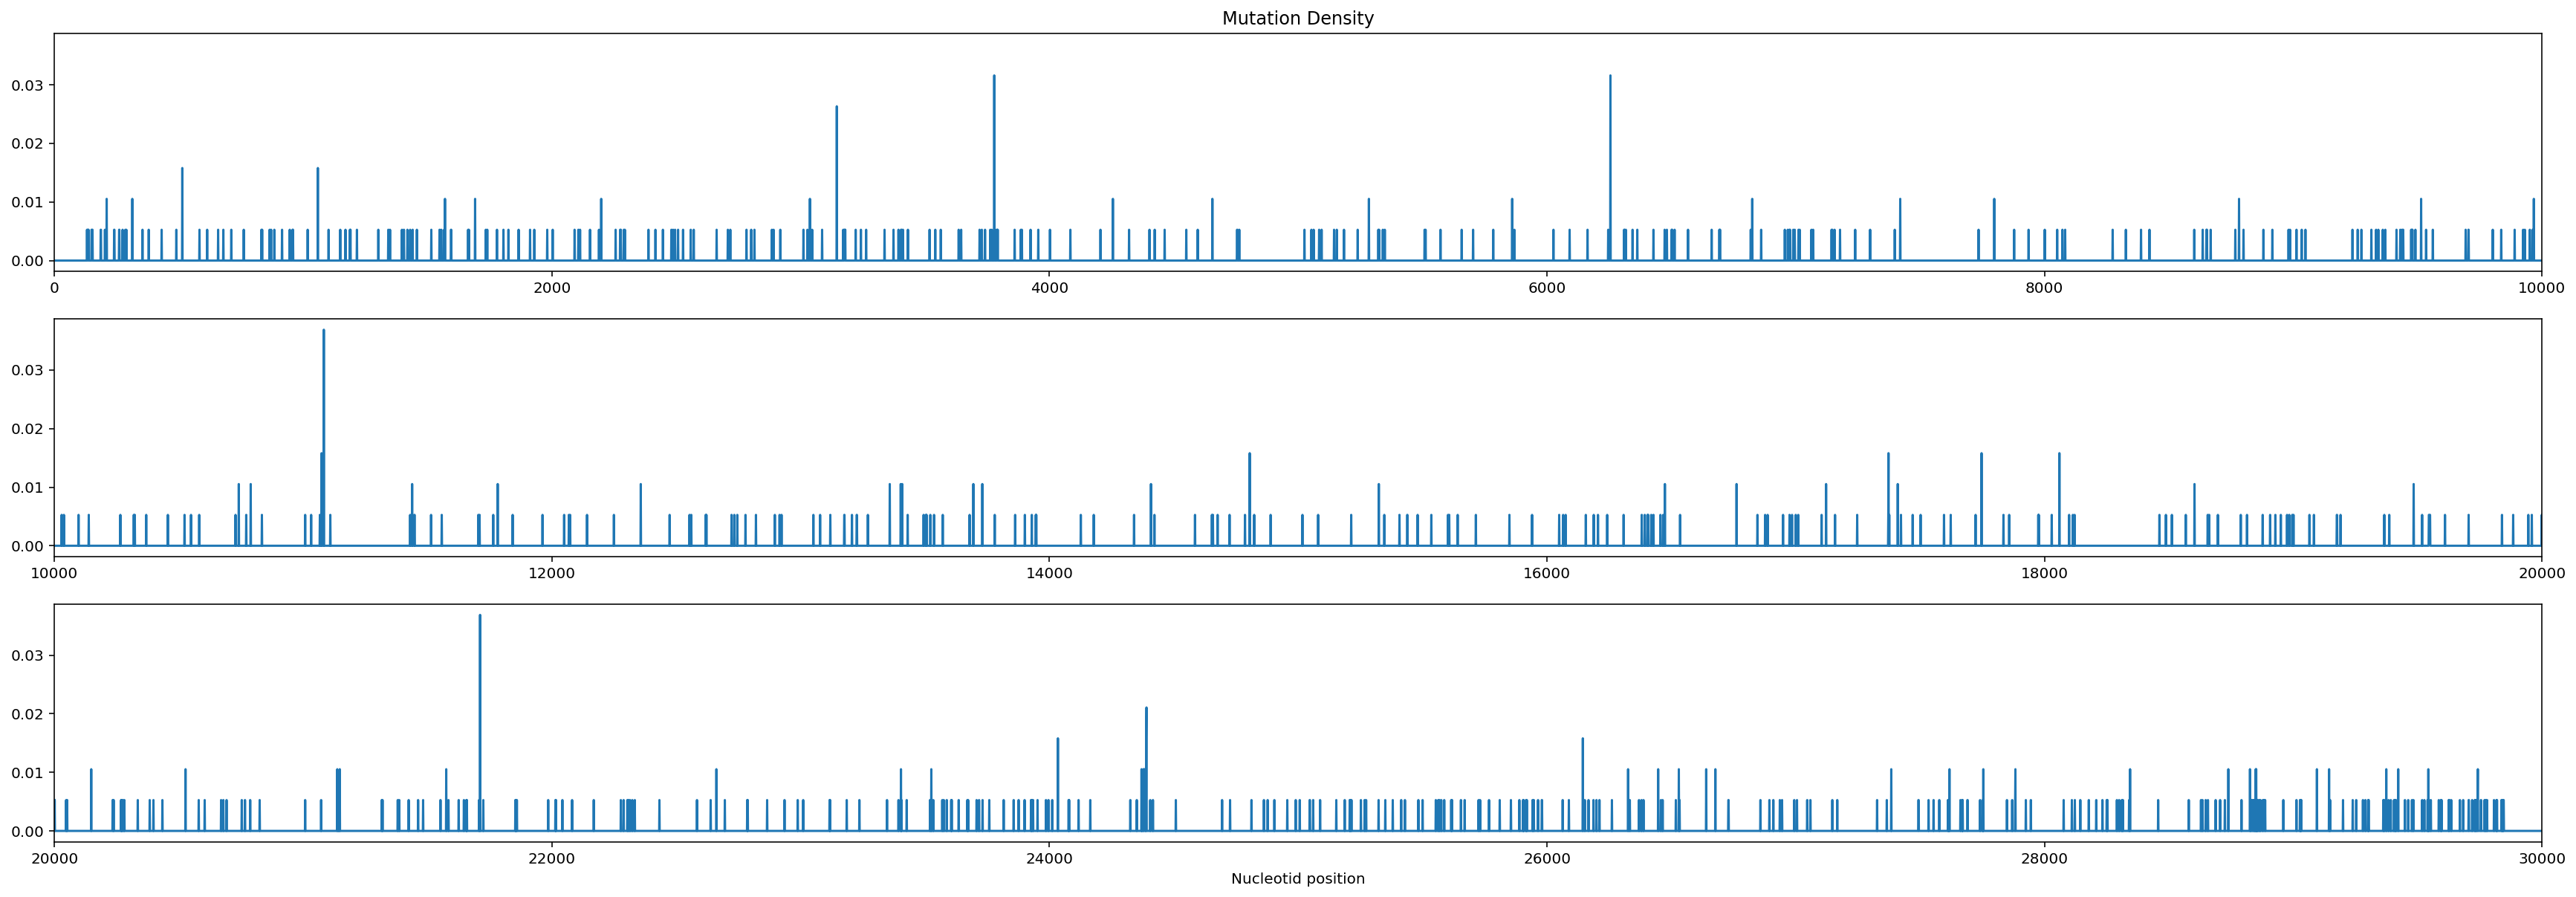

In [11]:
from sklearn.neighbors import KernelDensity

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 10))

#plt.figure(figsize=(30, 5))
kde = KernelDensity(kernel='tophat', bandwidth=0.1).fit(df['pos'].to_numpy().reshape(-1, 1))
s = np.arange(0,30000, 1)
e = kde.score_samples(s.reshape(-1,1))
ax1.plot(s, np.exp(e))
ax2.plot(s, np.exp(e))
ax3.plot(s, np.exp(e))

ax1.set_xlim(0, 10000)
ax2.set_xlim(10000, 20000)
ax3.set_xlim(20000, 30000)

ax1.set_title('Mutation Density')
ax3.set_xlabel("Nucleotid position");
#fig.savefig("mutation_density.png")

In [12]:
# is distribution uniform?
from scipy import stats
stats.kstest(df['pos'].to_numpy(), 'uniform')

KstestResult(statistic=1.0, pvalue=0.0)

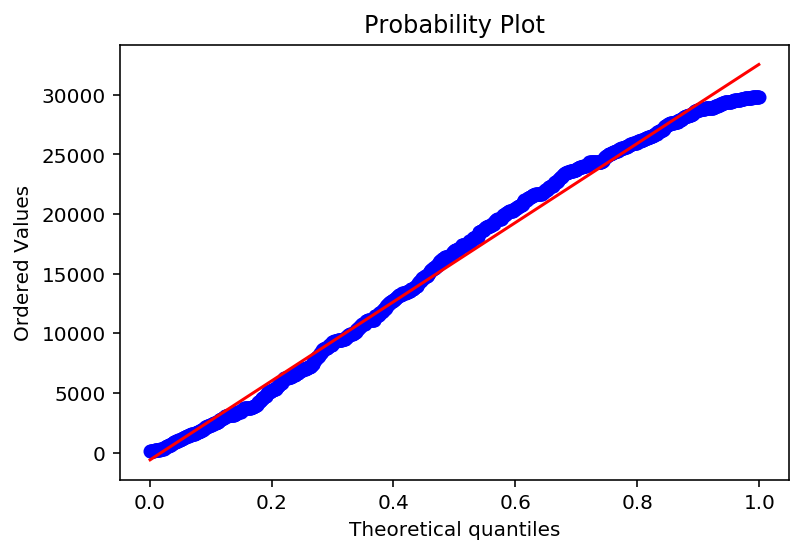

In [13]:
import pylab 
stats.probplot(df['pos'], dist="uniform", plot=pylab);
# not uniformaly distributed

SNPs are not uniformly distributed by position

# Generate all RNA sequences 

using one "root" node sequence and all nucleotide mutations

In [18]:
with open('./data/reference.gb') as fh:
    data = fh.read()

root_sequence = ''.join([c for c in re.match(".*ORIGIN(.*)", data, re.DOTALL).groups()[0] if c in ['a', 't', 'g', 'c']]).upper()
len(root_sequence)
#rootsequence.upper()

29903

In [27]:
def mutate_nuc(sequence, mutation_s):
    global c
    if not sequence:
        return []
    mutation_nuc_re = re.compile("([ACTG])(\d+)([ACTG])")
    m = mutation_nuc_re.match(mutation_s)
    if not m:
        return []
    from_, pos, to_ = m.groups()
    pos = int(pos)
    #assert(sequence[pos] == from_:)
    if sequence[pos] == from_:
        mutate_nuc.failed_match += 1
    nseq = list(sequence)
    nseq[pos] = to_
    return ''.join(nseq)

def generate_sequences(mutation_data, sequence):
    sequences = []
    
    if 'branch_attrs' in mutation_data and 'mutations' in mutation_data['branch_attrs']:
        for mut_type in mutation_data['branch_attrs']['mutations'].keys():
            if mut_type == 'nuc':
                sequences = [mutate_nuc(rootsequence, nuc_m) 
                            for nuc_m in mutation_data['branch_attrs']['mutations'][mut_type]]
    # recursively get each child's data and add that to a new list
    children_data = [d for child in mutation_data.get('children',[]) for d in generate_sequences(child, sequence)]
    # add our data to the start of the children's data
    return sequences + children_data


#print(len(root_sequence))
mutate_nuc.failed_match = 0
all_sequences = generate_sequences(ncov_json['tree'], root_sequence)

In [28]:
mutate_nuc.failed_match

205

We either 
- need to get the root node 
- simulate backward and then forward again